In [1]:
import pandas as pd # for data handling
import numpy as np # for linear algebra
import tensorflow as tf # for neural networks
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [2]:
latent_dim = 100

In [3]:
# get fashion mnist data
(x_train,y_train), (x_test,y_test) = keras.datasets.fashion_mnist.load_data()

# show shapes of tensors
print("x_train shape:", x_train.shape, ", y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, ", y_test shape:", y_test.shape)

# get number of classes
nClasses = len(np.unique(y_train)) # number of output classes
print("Number of classes: ", nClasses)

# normalize grayscale pixel values (0-255) to (0,1)
x_train = x_train.astype('float32')/255 # normalized training inputs
x_test = x_test.astype('float32')/255 # normalized test inputs

# show shapes of re-shaped tensors
print("x_train shape:", x_train.shape, ", y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, ", y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28) , y_train shape: (60000,)
x_test shape: (10000, 28, 28) , y_test shape: (10000,)
Number of classes:  10
x_train shape: (60000, 28, 28) , y_train shape: (60000,)
x_test shape: (10000, 28, 28) , y_test shape: (10000,)


In [4]:
#to build the GAN model
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import normal_latent_sampling, AdversarialOptimizerSimultaneous
from keras_adversarial.legacy import fit
import keras.backend as K
from keras.layers import Conv2D, Flatten, Activation, Dense, UpSampling2D, Reshape, BatchNormalization, AveragePooling2D
from keras.layers import BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.models import Sequential
from keras_adversarial.image_grid_callback import ImageGridCallback

In [5]:
def model_generator():
    model_g = keras.Sequential([
        #first Dense Layer
        Dense(3136,  input_shape=(100,), kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=TruncatedNormal(stddev=0.02)),
        BatchNormalization(epsilon=1e-5),
        Activation('relu'),
        Reshape([56, 56, 1]),

        #convolutional layer 1
        Conv2D(50, kernel_size = (3,3), strides=(2, 2), kernel_initializer=TruncatedNormal(stddev=0.02),bias_initializer=TruncatedNormal(stddev=0.02),  padding="same"),
        BatchNormalization(epsilon=1e-5),
        Activation('relu'),
        UpSampling2D(size=(2, 2)),

        #convolutional layer 2
        Conv2D(25, kernel_size = (3,3), strides=(2, 2), kernel_initializer=TruncatedNormal(stddev=0.02),bias_initializer=TruncatedNormal(stddev=0.02),  padding="same"),
        BatchNormalization(epsilon=1e-5),
        Activation('relu'),
        UpSampling2D(size=(2, 2)),

        #convolutional layer 3
        Conv2D(1, kernel_size=(1,1), strides=(2, 2), padding="same", kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=TruncatedNormal(stddev=0.02), activation ="sigmoid")],
        name="generator")
    return model_g


In [6]:
def model_discriminator():
    model_d = keras.Sequential([
        #convolutional layer 1
        Conv2D(32, kernel_size = (5,5), strides=(1, 1), kernel_initializer=TruncatedNormal(stddev=0.02), padding="same", input_shape=(28, 28, 1)),
        Activation('relu'),
        AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        
        #convolutional layer 2
        Conv2D(64, kernel_size = (5,5), strides=(1, 1), kernel_initializer=TruncatedNormal(stddev=0.02), padding="same"),
        Activation('relu'),
        AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        
        #first fully connected
        Flatten(),
        Dense(1024,  kernel_initializer=TruncatedNormal(stddev=0.02)),
        Activation('relu'),
        
        #keras.layers.Lambda( lambda image: tf.image.resize_images(size =[56, 56, 1])),
        #convolutional layer 3
        Dense(1, kernel_initializer=TruncatedNormal(stddev=0.02)),
        Activation('sigmoid')],
        name="discriminator")
    return model_d



In [7]:
def generator_sampler(latent_dim, generator):
    def fun():
        zsamples = np.random.normal(0, 1, size=(10 * 10, latent_dim))
        gen = dim_ordering_unfix(generator.predict(zsamples))
        return gen.reshape((10, 10, 28, 28))

    return fun

In [8]:
# generator (z -> x)
generator = model_generator()
    # discriminator (x -> y)
discriminator = model_discriminator()
gan = simple_gan(generator, discriminator, normal_latent_sampling((latent_dim,)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
generator.summary()
discriminator.summary()
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 50)        500       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 50)        200       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 50)        0         
__________

In [10]:
model = AdversarialModel(base_model=gan,
                             player_params=[generator.trainable_weights, discriminator.trainable_weights],
                             player_names=["generator", "discriminator"])
model.adversarial_compile(adversarial_optimizer=AdversarialOptimizerSimultaneous(),
                              player_optimizers=[Adam(0.0003, decay=1e-4), Adam(0.0003, decay=1e-4)],
                              loss='binary_crossentropy')

In [11]:
generator_cb = ImageGridCallback("output_blob/gan_convolutional/epoch-{:03d}.png",
                                     generator_sampler(latent_dim, generator))

In [12]:
def dim_ordering_fix(x):
    if K.image_dim_ordering() == 'th':
        return x
    else:
        return np.transpose(x, (0, 2, 3, 1))
    
def dim_ordering_unfix(x):
    if K.image_dim_ordering() == 'th':
        return x
    else:
        return np.transpose(x, (0, 3, 1, 2))
def dim_ordering_shape(input_shape):
    if K.image_dim_ordering() == 'th':
        return input_shape
    else:
        return (input_shape[1], input_shape[2], input_shape[0])

In [13]:
xtrain = dim_ordering_fix(x_train.reshape((-1, 1, 28, 28)))
xtest = dim_ordering_fix(x_test.reshape((-1, 1, 28, 28)))
y = gan_targets(xtrain.shape[0])

In [ ]:
ytest = gan_targets(xtest.shape[0])
history = model.fit(x=xtrain, y=y, validation_data=(xtest, ytest), callbacks=[generator_cb], nb_epoch=100,
                        batch_size=100)
df = pd.DataFrame(history.history)
df.to_csv("output_blob/gan_convolutional/history.csv")

In [102]:
generator.save("output_blob/gan_convolutional/generator.h5")
discriminator.save("output_blob/gan_convolutional/discriminator.h5")

In [103]:
print(history.history.keys())

dict_keys(['val_loss', 'val_generator_loss', 'val_generator_yfake_loss', 'val_generator_yreal_loss', 'val_discriminator_loss', 'val_discriminator_yfake_loss', 'val_discriminator_yreal_loss', 'loss', 'generator_loss', 'generator_yfake_loss', 'generator_yreal_loss', 'discriminator_loss', 'discriminator_yfake_loss', 'discriminator_yreal_loss'])


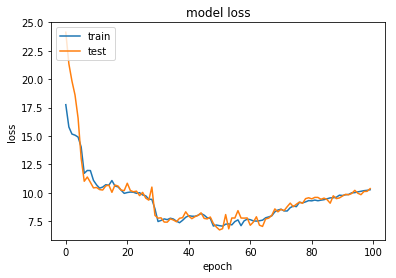

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()